## Preprocessing Of Files

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

In [3]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [5]:
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

In [7]:
print("TRUE:", df_true.columns)
print("FAKE:", df_fake.columns)

TRUE: Index(['title', 'text', 'subject', 'date'], dtype='object')
FAKE: Index(['title', 'text', 'subject', 'date'], dtype='object')


In [9]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [13]:
df_true['label'] = 0
df_fake['label'] = 1 

In [15]:
## Combine the datasets

df = pd.concat([df_true, df_fake], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

In [17]:
df

,title,text,subject,date,label
0,May might leave next stage of Brexit bill unti...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"October 18, 2017",0
1,CHILLING PHOTO Captures FEMALE SUICIDE BOMBER ...,Why would President Trump want America to enfo...,left-news,"Jul 9, 2017",1
2,Trump to meet with U.S. House Republicans Thur...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"November 13, 2017",0
3,White Trump Supporter Violently Attacks Musli...,This racist literally committed the hate crime...,News,"March 14, 2016",1
4,"Former Obama Adviser BLASTS Trump, Calls Him ...",Donald Trump has helped America s racists feel...,News,"January 10, 2016",1
...,...,...,...,...,...
44893,"South Africa's Dlamini-Zuma, ANC leadership co...",JOHANNESBURG (Reuters) - South African veteran...,worldnews,"September 8, 2017",0
44894,BRUTAL NEW BENGHAZI AD Exposes Hillary’s Embar...,You can run but you can t hide,left-news,"Jul 31, 2016",1
44895,Why The Death Of Justice Scalia Makes The Sup...,The death of Justice Antonin Scalia at the age...,News,"February 13, 2016",1
44896,REMEMBER WHEN Democrat Operatives Were Caught ...,Watch:. @Jordanfabian If there is no #VoterFra...,left-news,"Nov 28, 2016",1


In [19]:
## Text cleaning

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [21]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return ' '.join(words)

In [23]:
# Apply cleaning
df['cleaned_text'] = df['text'].astype(str).apply(clean_text)

In [25]:
df.to_csv('cleaned_reviews.csv', index=False)

## TF-IDF Vectorization

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
# Create the vectorizer with top 5000 features 
vectorizer = TfidfVectorizer(max_features=5000)

# Fit on the cleaned text and transform it into feature vectors
X = vectorizer.fit_transform(df['cleaned_text']).toarray()

# Labels (0 = genuine, 1 = fake)
y = df['label'].values

In [31]:
print("TF-IDF Feature Matrix shape:", X.shape)  # (rows, 5000 features)
print("Labels shape:", y.shape)

TF-IDF Feature Matrix shape: (44898, 5000)
Labels shape: (44898,)


In [33]:
import pickle

# Save the TF-IDF vectorizer
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

## Model Training

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [41]:
y_pred = model.predict(X_test)

In [43]:
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9320712694877505

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      4316
           1       0.93      0.94      0.94      4664

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980

Confusion Matrix:
 [[3975  341]
 [ 269 4395]]


In [45]:
import pickle

# Save the trained model
pickle.dump(model, open('model.pkl', 'wb'))

## Visualization

In [47]:
#pip install wordcloud

In [49]:
import warnings
warnings.filterwarnings("ignore")

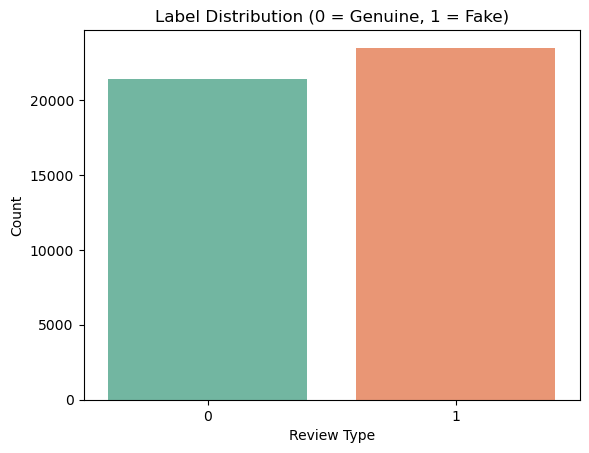

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df, palette='Set2')
plt.title('Label Distribution (0 = Genuine, 1 = Fake)')
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.show()

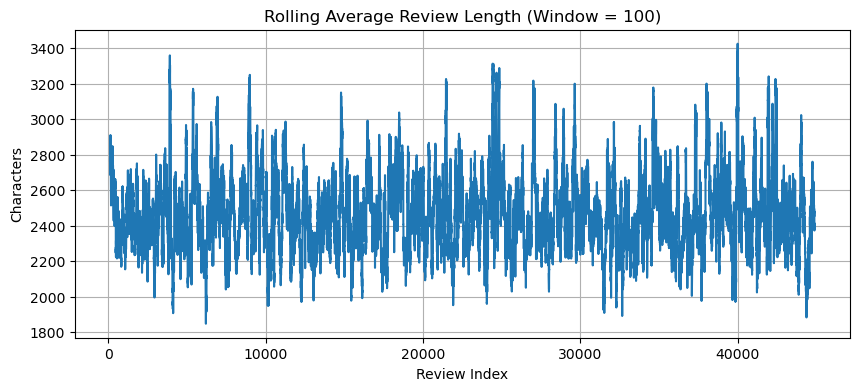

In [52]:
df['text_length'] = df['text'].astype(str).apply(len)

df['text_length'].rolling(100).mean().plot(figsize=(10,4))
plt.title('Rolling Average Review Length (Window = 100)')
plt.ylabel('Characters')
plt.xlabel('Review Index')
plt.grid()
plt.show()

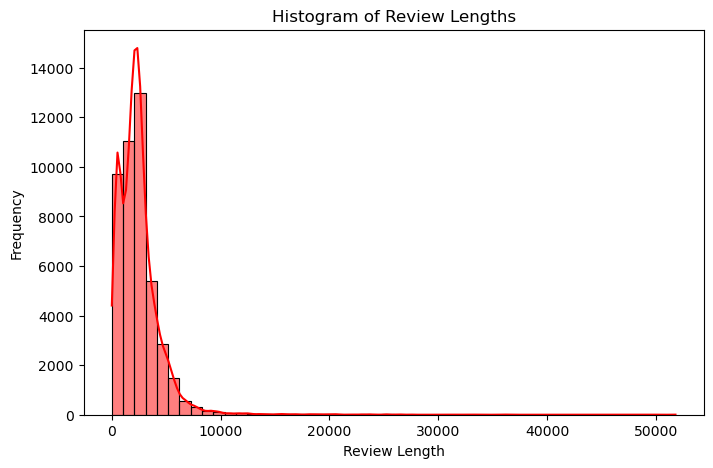

In [55]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='text_length', bins=50, kde=True, color='red')
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

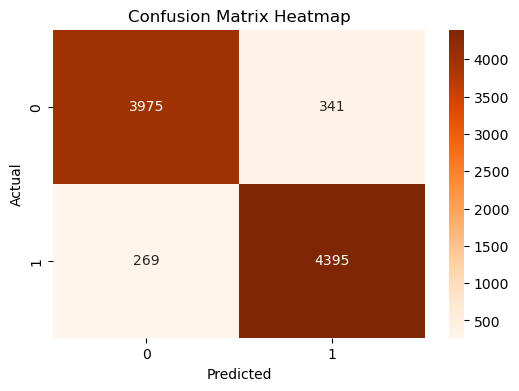

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [59]:
## WordCloud – Most Frequent Words in Fake and Real Reviews

In [61]:
from wordcloud import WordCloud

# WordCloud for Fake Reviews
fake_text = ' '.join(df[df['label'] == 1]['cleaned_text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)

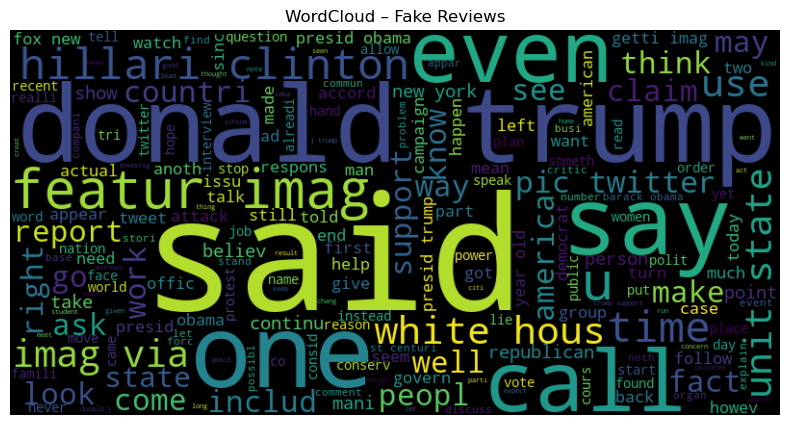

In [63]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('WordCloud – Fake Reviews')
plt.axis('off')
plt.show()

In [65]:
# WordCloud for Genuine Reviews
true_text = ' '.join(df[df['label'] == 0]['cleaned_text'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)

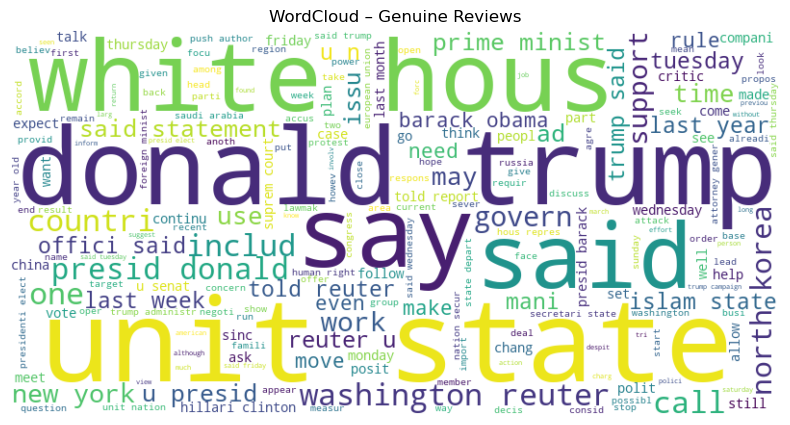

In [66]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('WordCloud – Genuine Reviews')
plt.axis('off')
plt.show()